In [107]:
%matplotlib inline
from hyperopt.mongoexp import MongoTrials
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.externals import joblib
import matplotlib as mpl
mpl.rc('lines', linewidth=2, color='r', markersize=10)
mpl.rc('axes', labelpad=14, labelsize=14)
mpl.rc('legend', borderpad=.5, fontsize='large')
#mpl.rc('xtick', labelsize=11)
#mpl.rc('ytick', labelsize=11)

In [108]:
exp_type = 'svr_nonlin'
db_path = 'mongo://localhost:1234/' + exp_type + '/jobs'
trials = MongoTrials(db_path)
print 'num trials in exp: {}'.format(len(trials.results))

ftp://localhost:1234/svr_nonlin/jobs
ParseResult(scheme='ftp', netloc='localhost:1234', path='/svr_nonlin/jobs', params='', query='', fragment='')
num trials in exp: 500


In [109]:
#load 
save_root = 'results/' + exp_type
save_name = 'search_histories.pkl'
save_path = os.path.join(save_root, save_name)
results_hist = joblib.load(save_path)
loss_hist_array, best_hist_array, val_hist_array = results_hist['loss'], results_hist['best'], results_hist['val_of_best']

In [99]:
def plot_optimisation(ax, num_trials, loss_hist_array, best_hist_array, alpha=1):
    ax.plot(loss_hist_array[:num_trials,1], 1-loss_hist_array[:num_trials,0], 'k--', alpha=alpha)
    #ax.plot(best_hist_array[:num_trials,1], 1-best_hist_array[:num_trials,0], 'ro', alpha=alpha)
    
    inds, = np.where(best_hist_array[:,1]<num_trials)
    ax.plot(best_hist_array[inds,1], 1-best_hist_array[inds,0], 'bo', alpha=alpha)
    
    #labels
    ax.set_xlabel('SMBO iteration')
    ax.set_ylabel('$R^2$', fontsize=16)
    ax.grid()
    ax.set_xlim([-10, num_trials+10])
    return ax

## SMBO plot

(0.56, 0.62)

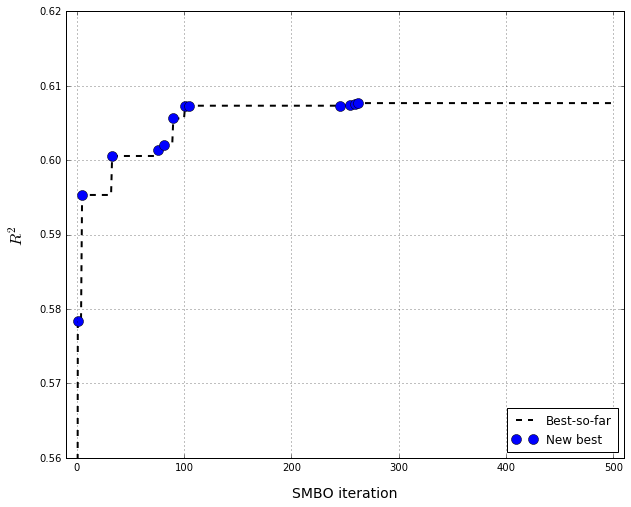

In [114]:
num_trials = 500
f, ax = plt.subplots(figsize=(10,8))
ax = plot_optimisation(ax, num_trials, loss_hist_array, best_hist_array, alpha=1)
ax.legend(['Best-so-far', 'New best'], loc='lower right')
ax.set_ylim([.56, .62])

#save_path = 'results/' + exp_type + '/smbo.png'
#f.savefig(save_path)

## Best config regression plot

In [101]:
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.metrics.pairwise import linear_kernel
from sklearn.externals import joblib
from multichannel import MultiChannelModel, multichannel_KFoldCV, theano_rbf as rbf_kernel, theano_chi2 as chi2_kernel
import numpy as np
import csv, os, time

#load the dataset
dataset_root = '/home/luke/projects/THE_dataset' #directory where features/labels kept
train_path = os.path.join(dataset_root, 'train_set_wc3d.pkl')
test_path = os.path.join(dataset_root, 'test_set_wc3d.pkl')
X_train, y_train = joblib.load(train_path)
X_test, y_test = joblib.load(test_path)

def create_kpt(num_channels, gammas):
    kernel_param_list = []
    for channel in xrange(num_channels):
        if channel < 4:
            kdict = {'kernel_func': chi2_kernel, 'param_dict': {'gamma': gammas[channel]}}
        elif channel == 5:
            kdict = {'kernel_func': rbf_kernel, 'param_dict': {'gamma': gammas[channel]}}
        kernel_param_list.append(kdict)
    kernel_param_tuple = tuple(kernel_param_list)
    return kernel_param_tuple

def extract_config(trials, tid, return_code=0, reg_type='ridge'):
    if tid == 'best':
        best_config = dict(trials.best_trial['misc']['vals'])
    else:
        best_config = dict(trials.trials[tid]['misc']['vals'])
        
    if reg_type=='ridge':
        alpha = best_config['ridge_alpha'][0]
    else:
        alpha = best_config['svr_C'][0]
        
    if return_code == 0:
        kpt = {'kernel_func': linear_kernel, 'param_dict':{}}
        cw = None
        return alpha, kpt, None
    elif return_code == 1:
        gammas = [best_config['traj_gamma'][0], best_config['hog_gamma'][0], best_config['hof_gamma'][0], 
                  best_config['mbhx_gamma'][0], best_config['mbhy_gamma'][0], best_config['c3d_gamma'][0]]
        kpt = create_kpt(6, gammas)
        return alpha, kpt, None
    elif return_code == 2:
        gammas = [best_config['traj_gamma'][0], best_config['hog_gamma'][0], best_config['hof_gamma'][0], 
                  best_config['mbhx_gamma'][0], best_config['mbhy_gamma'][0], best_config['c3d_gamma'][0]]
        kpt = create_kpt(6, gammas)
        cw = [best_config['traj_cw'][0], best_config['hog_cw'][0], best_config['hof_cw'][0], 
              best_config['mbhx_cw'][0], best_config['mbhy_cw'][0], best_config['c3d_cw'][0]]
        return alpha, kpt, cw
    elif return_code == 3:
        gammas = [0.06386, 0.117941, 0.060457, 0.180092, 3405.482, 0.79326]
        kpt = create_kpt(6, gammas)
        cw = [best_config['traj_cw'][0], best_config['hog_cw'][0], best_config['hof_cw'][0], 
              best_config['mbhx_cw'][0], best_config['mbhy_cw'][0], best_config['c3d_cw'][0]]
        return alpha, kpt, cw
    else:
        ValueError('incorrect return code supplied')

alpha, kpt, cw = extract_config(trials, tid='best', return_code=1, reg_type='svr')
model = SVR(kernel='precomputed', C=alpha)
#model = Ridge(alpha=alpha)
mcm = MultiChannelModel(num_channels=6, model=model, kernel_param_tuple=kpt, channel_weights=cw)
mcm.fit(X_train, y_train)
y_pred = mcm.predict(X_test)
score = np.corrcoef(y_test, y_pred)[0,1]**2
print score

0.627434671086


### print best config

In [106]:
dict(trials.best_trial)

{u'_id': ObjectId('572b3aab510eac6b0a5e631b'),
 u'book_time': datetime.datetime(2016, 5, 5, 12, 21, 48, 443000),
 u'exp_key': None,
 u'misc': SON([(u'tid', 268), (u'idxs', SON([(u'hof_gamma', [268]), (u'svr_C', [268]), (u'mbhy_gamma', [268]), (u'hog_gamma', [268]), (u'traj_gamma', [268]), (u'c3d_gamma', [268]), (u'mbhx_gamma', [268])])), (u'cmd', [u'domain_attachment', u'FMinIter_Domain']), (u'vals', SON([(u'hof_gamma', [0.07271759288516493]), (u'svr_C', [5.612053092224692]), (u'mbhy_gamma', [18.297798578093797]), (u'hog_gamma', [0.10584102051488271]), (u'traj_gamma', [0.03973091601387516]), (u'c3d_gamma', [0.7448057839668178]), (u'mbhx_gamma', [0.14148162765679317])])), (u'workdir', None)]),
 u'owner': [u'nilli15:5524'],
 u'refresh_time': datetime.datetime(2016, 5, 5, 12, 22, 37, 202000),
 u'result': SON([(u'status', u'ok'), (u'loss', 0.39232548677316226), (u'eval_time', 1462450957.201771)]),
 u'spec': None,
 u'state': 2,
 u'tid': 268,
 u'version': 3}

In [103]:
#visualise
def plot_regression(y_test, y_pred, score=None, scatter_color='blue', title=' '):
    
    #plot on axis
    fig, ax = plt.subplots(figsize=(10,8))
    ax.scatter(y_test, y_pred, alpha=.2, s=120, color=scatter_color)
    
    #perfect model line
    ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
            linestyle='-', color='k', label='Perfect prediction')
    
    #line of best fit to the learned model
    par = np.polyfit(y_test, y_pred, 1, full=True)
    m = par[0][0]; c=par[0][1]
    model_line_x = [min(y_test), max(y_test)]
    model_line_y = [m*x + c for x in model_line_x]
    ax.plot(model_line_x, model_line_y, 
            linestyle='--', color=scatter_color, label='Model prediction')
    
    #put in the R score
    if score:
        ax.text(model_line_x[1]-.4, model_line_y[1]+.4, r'$R^2={:.2f}$'.format(score), fontsize=14, color=scatter_color)
    
    #axis formatting
    ax.set_xlim([10,45])
    ax.set_ylim([10,45])
    ax.set_xlabel(r'Observed perceptual load')
    ax.set_ylabel(r'Predicted perceptual load')
    ax.set_title(title)
    
    #misc
    ax.legend()
    ax.grid(True)
    
    return fig, ax

(<matplotlib.figure.Figure at 0x7fee335fe7d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fee29ae7ed0>)

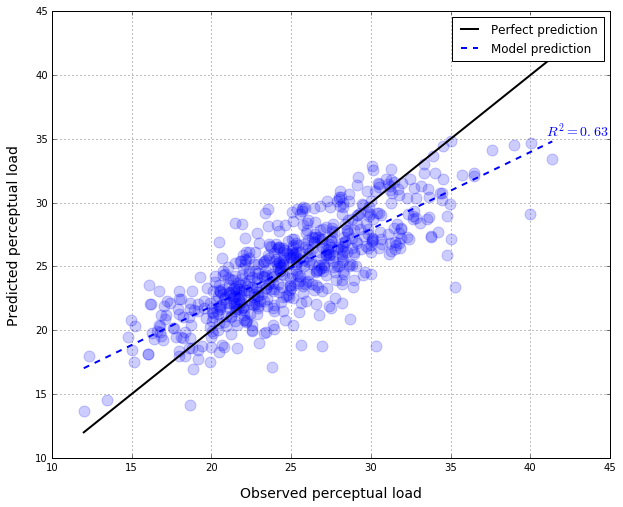

In [104]:
plot_regression(y_test, y_pred, score=score)

## SMBO + validation plot

(0.525, 0.65)

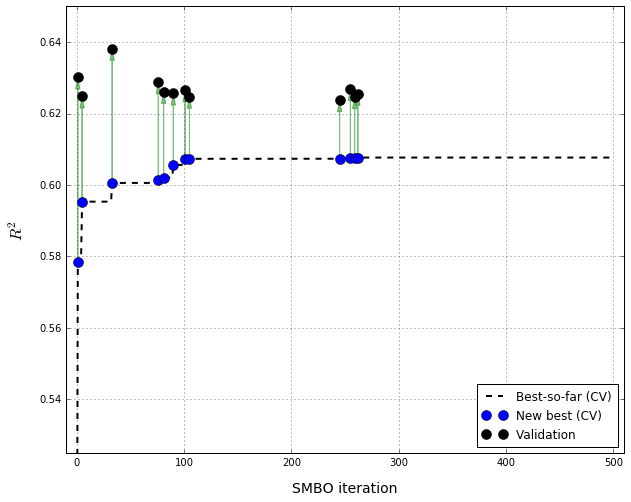

In [111]:
num_trials = 500
f, ax = plt.subplots(figsize=(10,8))
ax = plot_optimisation(ax, num_trials, loss_hist_array, best_hist_array, alpha=1)
#add in val hist
inds, = np.where(val_hist_array[:,1]<num_trials)
ax.plot(val_hist_array[inds,1], val_hist_array[inds,0], 'ko', alpha=1)
ax.legend(['Best-so-far (CV)', 'New best (CV)', 'Validation'], loc='lower right')

#add connecting lines
for ind in inds:
    x, y = best_hist_array[ind, 1], 1-best_hist_array[ind, 0]
    dx, dy = 0, -((1-best_hist_array[ind, 0])-(val_hist_array[ind, 0]))
    head_length = .003
    if dy < 0:
        dy += head_length
        dy += .00025
        col = 'r'
    else:
        dy -= head_length
        dy -= .00025
        col = 'g'
    ax.arrow(x, y, dx, dy, head_width=4, head_length=head_length, fc=col, ec=col, lw=1, alpha=.5)
    
ax.set_ylim([.525, .65])